# Assignment 4: Clustering and PCA

### Lauren Enriquez

In [1]:
#Imports headers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from scipy import stats
import random

## Part 1: Parsing data

You’re given a dataset of gene expression for 20 samples that might represent different biological situations. 

- Read in the data as a matrix of n rows (number of samples) by m (number of genes measured for each sample). **Each sample (row) is a data point, and each gene (column) is a feature**.

- Normalize the data: calculate the mean expression for each gene, and rescale each individual measurement relative to that mean (giving the fold change relative to the mean). 

- Then, log_2 transform the data.

In [2]:
#Reads in data
data = np.loadtxt(open("gene_expression.csv"), delimiter=",", skiprows=1, usecols=range(1,101))

#Normalizes data
normalized_data = normalize(data, axis=0, norm ='l1')

#Log2 transforms the data
data_log =np.log2(normalized_data)

#Zero means the data
data_final = data_log - np.mean(data_log, axis = 0)

## Part 2: PCA
We want to be able to distill the most important aspects, both for the purposes of visualization and de-noising. It may be the case that only the *d* most important axes of variation contribute significantly to our understanding of the data.

### 2.1: Plot the singular values of the matrix
In the cell below, create a chart comparing the singular values of the data matrix. Your x-axis should range from 1 to *m* (total dimension of the vector space), and your y-axis should plot the singular values in order from greatest to least. Feel free to use `np.linalg.svd`.

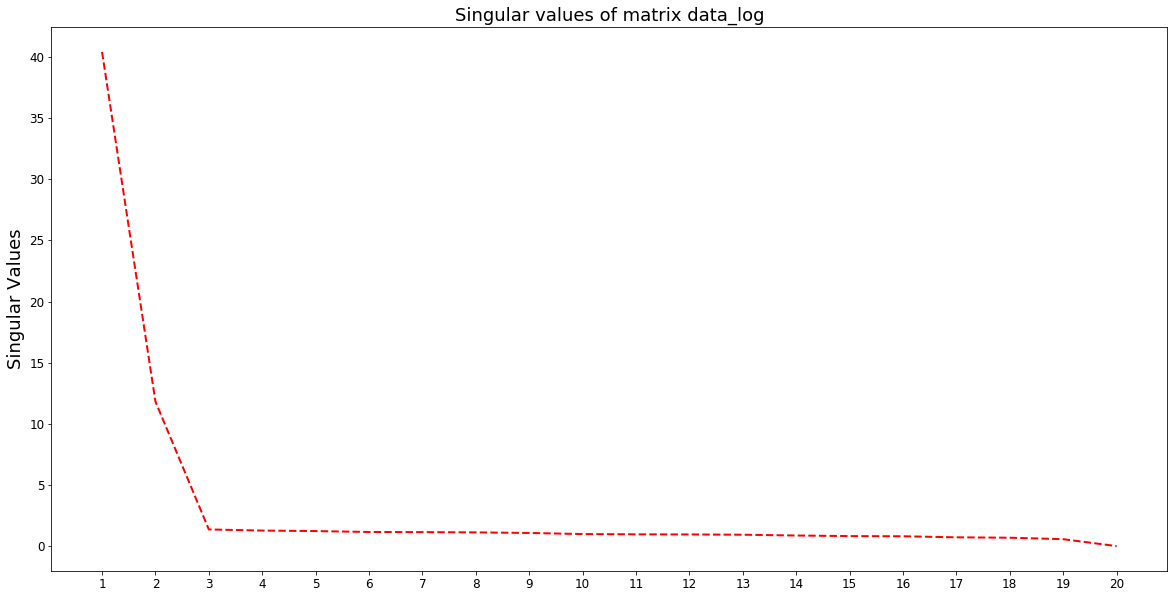

In [3]:
#Create x-axis range 1 - 20 (the total dimension of the vector space)
T = [i for i in range(1,21)]

#Calculates the SVD of the data_final
u, s, v = np.linalg.svd(data_final, full_matrices= True)

#Creates the plot of the singular values of the matrix
plt.figure(figsize=(20,10))
plt.axis(xlim=(1, 101))
plt.xticks(range(0, 101), size = 12)
plt.yticks(size = 12)
plt.ylabel('Singular Values', size = 18)
plt.plot(T,s, 'r--',linewidth=2.0)
plt.title("Singular values of matrix data_log", size = 18)
plt.show()

### 2.2 Choosing *d*:
Based on the values you plotted, what should we set *d* to be for our purposes? Where's the cutoff in your judgement for the small set of useful features?



In [4]:
d = 3

### 2.3: PCA Derivation/Motivation
**Please scan and attach your written work to the submission pdf.**

Let us assume that our data is drawn from a multivariate Gaussian distribution. Suppose we compute the singular value decomposition of our data matrix to be $X = U\Sigma V^{\intercal}$.

1) What are the major properties of the matrices $U$, $V$ and $\Sigma$? (Describe them like, $U$ is a \_\_\_\_ matrix)

3) What is $X^\intercal X$ in terms of $U$, $V$ and $\Sigma$? Make sure you simplify based on the properties you described in part 1. As a hint, your answer should be a product of three terms.

4) We know that $$\frac{1}{n} X^\intercal X$$ is the sample covariance matrix if we assume that each $X_i$ is drawn from a Gaussian distribution. This means it describes the joint variance of the features. Given this Gaussian, how may we construct a *d* dimensional basis to project our data? In other words, which vectors from $U$, $V$, etc do we take to be our projection basis? Hint: These vectors represent the directions with the greatest variance.

(Note 1: we're trying to pick a vector basis with the highest variance because it will give us the most predictive power. Imagine trying to project to a basis where every data point gets projected to a similar or low-varying area. How are you going to classify anything? High variance ensures points are likely to be spread apart and thus more easily classified or clustered into distinct categories.)

(Note 2: additionally, because our basis is orthonormal, we gain the advantage that the features we pick don't "interfere" with each other, and "describe" distinct aspects of the data.)


### 2.4: Collect Basis Vectors
Based on your answer to question 4, collect a basis of vectors that you will be projecting the data onto. The basis should be of length *d* (decided upon in section 2.2).

In [5]:
#Collects Basis of vectors by the transpose of the first 3 columns (d) of matrix v (derived from the SVD calculation)
basis = np.transpose(v[:2])
print(basis.shape)

(100, 2)


## Part 3: Projection

### 3.1: Projection function
Please fill in the function below, which projects a given vector and sends it to the space described by the input basis. Because the basis we're going to be using is orthonormal, we can use the formula described at https://home.apu.edu/~smccathern/PastCourses/F12/LinearAlgebra/LA5_1handout.pdf (Theorem 7)

In [6]:
def project(v, basis):
    """Takes a vector v and projects it into the space spanned by basis.
    
    Args:
        v: data vector (1-D numpy array)
        basis: an _orthonormal_ basis of vectors
        
    Returns:
        a 1-D numpy array, the projected vector
    """
    x = np.dot(v,basis)
    
    return x

### 3.2: Project & Plot
We've chosen the dimension of our projection. We've chosen the vectors that will give us the most descriptive projection subspace. Now we just need to project our data and plot it.

Please use the function in 3.1 and create a scatterplot of your projected data.

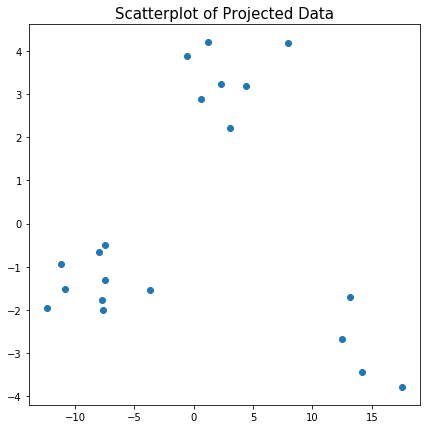

In [7]:
#Creates projected data using project function
gene_transform = project(data_final,basis)

#Creates scatterplot of projected data
plt.figure(figsize=(7,7))
plt.title('Scatterplot of Projected Data', size = 15)
plt.scatter(gene_transform[:,0], gene_transform[:,1])
plt.show()

## Part 4: Clustering
Consider the scatterplot you've made. How many natural clusters do you think the data seems to form?

In [8]:
k = 3

We're going to be employing the k-means algorithm, a form of unsupervised learning. The algorithm will produce an assignment of each data point to one of _k_ clusters (coloring your scatterplot *k* colors). A "cluster" is loosely defined by "the collection of points gathered around a center point (centroid)" The reason it's unsupervised is because we're not given any training data or labels, but we still have to infer a label for each data point.

### 4.1: Understanding k-means Psuedocode
**Variables**:

$k$: the number of clusters

$x_1, \ldots, x_n$: the data (vectors)

$l_1, \ldots, l_n$: the corresponding label of each datapoint (scalars, value in interval \[1, k\])

$c_1, \ldots, c_k$: the centroids of each cluster (vectors)



**Algorithm**:

    Initialize $c_1, ..., c_n$ randomly.

    while (centroids still move more than $\epsilon$ distance, for some small $\epsilon > 0$)

        Assign each $l_i$ label for each point $x_i$ to the nearest centroid's index (if $c_3$ is the closest to $x_i$, set $l_i$ to be 3)
        
        Update each centroid $c_i$ to be the average of all the $x_i$ points currently assigned to its cluster
        
  



You may notice this functions kind of like the EM algorithm in that we update the centroid (hidden state) and our labels for the data in a loop based on each other. In fact, one might say that k-means is a non-probabilistic ("hard") version of EM specifically for clustering.

In [9]:
#Creates a function that calculates the Euclidean distance
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

### 4.2: Implement k-means

In [10]:
def kmeans(xs, k):
    """Performs k-means clustering as described above.
    
    Args:
        xs: list of vectors/data
        k: the number of clusters to form
    
    Returns:
        ls: list of corresponding labels for each data point, denoting which cluster each point belongs to
    """
    eps = 1e-8
    
    # initialize centroids of clusters
    cs = []  # list of centroids
    for i in range(k):
        y = int((len(xs)/ k)* (i-1))
        z = int((len(xs)/ k)* i)
        x = xs[random.randint(y,z)]
        cs.append(x)

    # Creates initial old centroids  
    cs_old = np.zeros((len(cs),2))
    
    # Creates initial Euclidean distance between the new centroids and the old centroids
    cs_dist = dist(cs, cs_old)
    
    # labels
    ls = [0 for i in range(len(xs))]
    
    # MAIN LOOP: 
    # Occurs when the cs_dist is more than eps
    while (cs_dist > eps).any()  :
        # assign labels
        for i in range(len(xs)):
            # TODO: assign label
            
            # Calculates the Euclidean distance of all the points in xs to the centroids
            distances = dist(xs[i], cs)
            cluster = np.argmin(distances)
            
            # Assign approipiate labels of each xs for the nearest centroid
            ls[i] = cluster
            
        # recalculate centroids
        
        # Creates a copy of the old centroids to compare to the new centroids in the next step
        cs_old = np.array(cs)
        
        for i in range(k):
            # TODO: recalculate centroid position
            points = [xs[j] for j in range(len(xs)) if ls[j] == i]
            cs[i] = np.mean(points, axis=0)
         
        # Calculates the Euclidean distance between the new centroids and the old centroids
        cs_dist = dist(cs, cs_old, None)
    
    return ls

### 4.3 Plot projected data with color labels
Use the 'c' argument in `plt.scatter` and the list of labels you derived to color the scatter plot you created in 3.2.

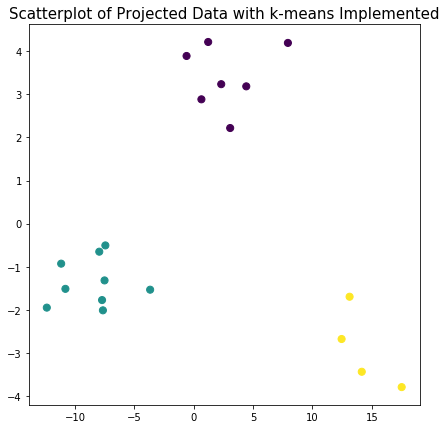

In [11]:
#Conducts k-means function on the projected data
gene_label = kmeans(gene_transform, k)

#Creates scatterplot of projected data with k-means implemented (k = 3)
plt.figure(figsize=(7,7))
plt.title('Scatterplot of Projected Data with k-means Implemented', size = 15)
plt.scatter(gene_transform[:, 0], gene_transform[:, 1], c= gene_label, s=50, cmap='viridis')
plt.show()

Written by Andrew Li for BioE 145 Spring 2020 at UC Berkeley.